In [1]:
import os

import numpy as np
import torch
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

from models.nn import ShiftedConv
from models.convnext import ConvNeXt
import cpc

/home/S-rs/miniforge3/envs/embed_time/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
GPU = 0
n_test = 100
seed = 1
batch_size = 4
version = 0 # first training this will be zero
model_name = "ben_model_03_pp_norm"
base_dir = "/mnt/efs/dlmbl/G-et/checkpoints/time-series"
checkpoint_dir = Path(base_dir) / f"2024-09-03_{model_name}_checkpoints/version_{str(version)}"
latent_dims = 64

torch.manual_seed(seed)
device = torch.device(f"cuda:{str(GPU)}")

In [3]:
from embed_time.transforms import CustomToTensor, CropAndReshapeTL
from embed_time.dataloader_rs import LiveTLSDatasetPairedOutput
from torchvision.transforms import v2
import torchvision.transforms as trans

data_location = "/mnt/efs/dlmbl/G-et/data/live-TLS"

folder_imgs = data_location +"/"+'Control_Dataset_4TP_Normalized_Across_Plates'
annotations = data_location + "/" +'Control_Dataset_4TP_Ground_Truth'


loading_transforms = trans.Compose([
    CropAndReshapeTL(1,0,598,0),
    CustomToTensor(),
    v2.Resize((576,576)),
])

torch.manual_seed(seed)
device = torch.device(f"cuda:{str(GPU)}")
dataset_w_t = LiveTLSDatasetPairedOutput(
    annotations,
    folder_imgs,
    indices=range(312),
    transform = loading_transforms,
)


train_loader = torch.utils.data.DataLoader(
    LiveTLSDatasetPairedOutput(
        annotations,
        folder_imgs,
        indices=range(312),
        transform = loading_transforms,
    ),
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
)



In [4]:
n_time = 4

encoder = ConvNeXt(in_chans=2, num_classes=latent_dims, dims=[16, 32, 64, 128])
ar_model = ShiftedConv(in_channels=latent_dims, out_channels=latent_dims, kernel_size=n_time)
query_weights = torch.nn.ModuleList()
for _ in range(n_time - 1):
    query_weights.append(torch.nn.Linear(latent_dims, latent_dims))

In [5]:
encoder.load_state_dict(
    torch.load(os.path.join(checkpoint_dir, "encoder.pt"), weights_only=True)
)
ar_model.load_state_dict(
    torch.load(
        os.path.join(checkpoint_dir, "ar_model.pt"), weights_only=True
    )
)
query_weights.load_state_dict(
    torch.load(
        os.path.join(checkpoint_dir, "query_weights.pt"), weights_only=True
    )
)

<All keys matched successfully>

In [6]:
def test(test_loader,
         encoder,
         ar_model,
         query_weights,
):
        encoder = encoder.to(device)
        ar_model = ar_model.to(device)
        query_weights = query_weights.to(device)
        encoder.eval()
        ar_model.eval()
        query_weights.eval()
        latents_list = []
        context_list = []
        with torch.no_grad():
            for batch in tqdm(
                test_loader,
                bar_format=f"Predicting {{l_bar}}{{bar}}{{r_bar}}",
            ):
                batch_size = batch.shape[0]
                batch = batch.to(device)
                context, latents = cpc.forward(
                    batch, batch_size=batch_size, encoder=encoder, ar_model=ar_model
                )
                latents_list.append(latents)
                context_list.append(context)
        return latents_list, context_list

In [7]:
embeddings = test(
    test_loader=train_loader,
    encoder=encoder,
    ar_model=ar_model,
    query_weights=query_weights,
)
latents, context = embeddings
latents = torch.cat(latents, dim=0).cpu()
context = torch.cat(context, dim=0).cpu()

Predicting   0%|          | 0/78 [00:00<?, ?it/s]

Predicting 100%|██████████| 78/78 [00:43<00:00,  1.81it/s]


In [8]:
latents_reshape = latents.movedim(2,0).flatten(0,1)
latents_reshape.shape

torch.Size([1248, 64])

In [9]:
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaled_latents = StandardScaler().fit_transform(latents_reshape)
scaled_latents.shape

(1248, 64)

In [16]:
umap = UMAP(n_neighbors=10).fit_transform(scaled_latents)
pca = PCA(n_components=3).fit_transform(scaled_latents)

<Axes: >

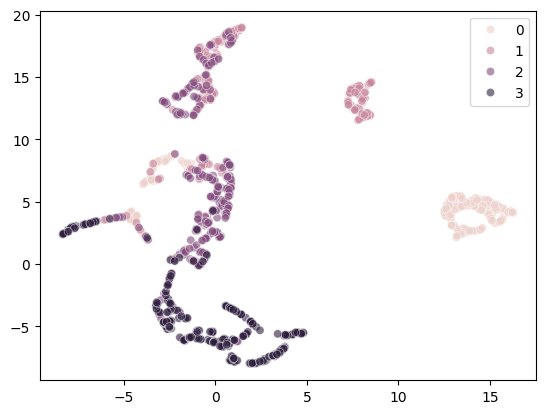

In [17]:
import seaborn as sns
time_labels = [i//312 for i in range(len(latents_reshape))]
sns.scatterplot(x=umap[:,0],y=umap[:,1],hue=time_labels,alpha=0.6)

In [20]:
scaled_context = StandardScaler().fit_transform(context.movedim(2,0).flatten(0,1))
umap_context = UMAP(n_neighbors=10).fit_transform(scaled_context)
pca_context = PCA(n_components=3).fit_transform(scaled_context)


<Axes: >

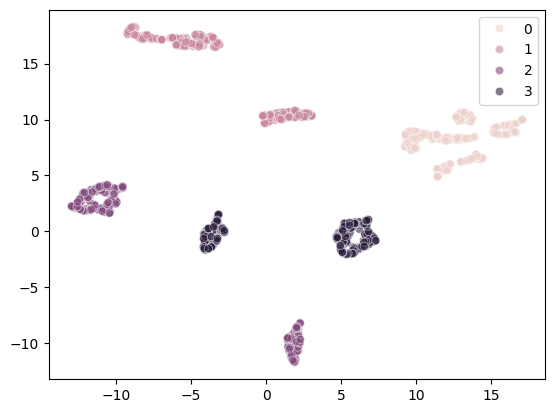

In [21]:
sns.scatterplot(x=umap_context[:,0],y=umap_context[:,1],hue=time_labels,alpha=0.6)

In [22]:
from embed_time.dataloader_rs import LiveTLSDataset

metadata_loader = LiveTLSDataset(
    annotations,
    folder_imgs,
    transform = loading_transforms,
    metadata_columns=["Axes","Run","Plate","ID"],
    return_metadata=True
)

labels = []
metadata = []

for sample in metadata_loader:
    _, label, metdat = sample
    labels.append(label)
    metadata.append(metdat)

In [23]:
labels[:10]

['good', 'bad', 'bad', 'good', 'bad', 'bad', 'bad', 'bad', 'bad', 'good']

In [24]:
metadata[:5]

[('single', 'RR', np.int64(1), 'A1'),
 ('single', 'RR', np.int64(1), 'A2'),
 ('single', 'RR', np.int64(1), 'A3'),
 ('single', 'RR', np.int64(1), 'A4'),
 ('single', 'RR', np.int64(1), 'A5')]

In [25]:
axis_labels = [meta[0] for meta in metadata]
axis_labels[:5]

['single', 'single', 'single', 'single', 'single']

In [26]:
plate_labels = [f"{meta[1]}_{meta[2]}" for meta in metadata]
np.unique(plate_labels)

array(['RR_1', 'RR_4', 'RR_6', 'TR_1', 'TR_2'], dtype='<U4')

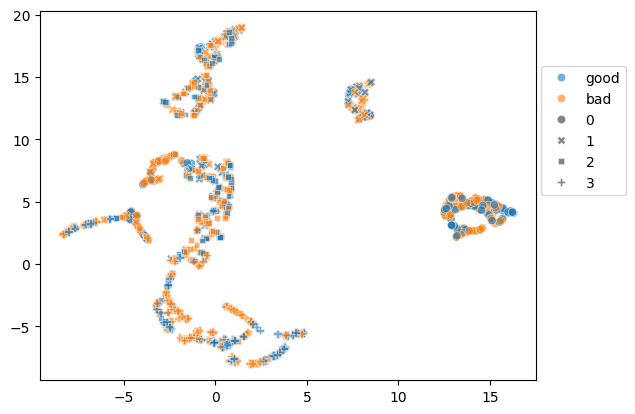

In [27]:
ax = sns.scatterplot(x=umap[:,0],y=umap[:,1],hue=labels*4,alpha=0.6,style=time_labels)
sns.move_legend(ax,(1.01,0.5))

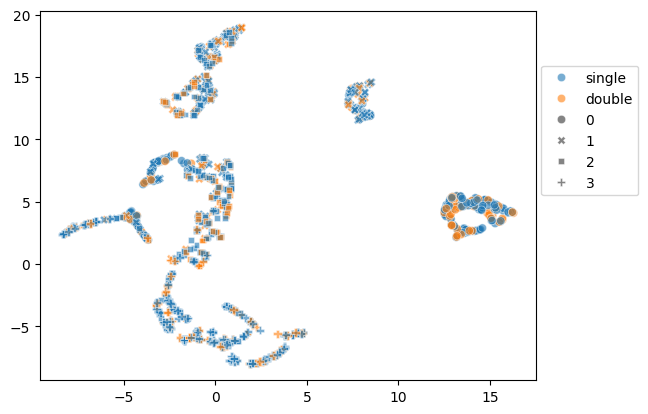

In [28]:
ax = sns.scatterplot(x=umap[:,0],y=umap[:,1],hue=axis_labels*4,alpha=0.6,style=time_labels)
sns.move_legend(ax,(1.01,0.5))

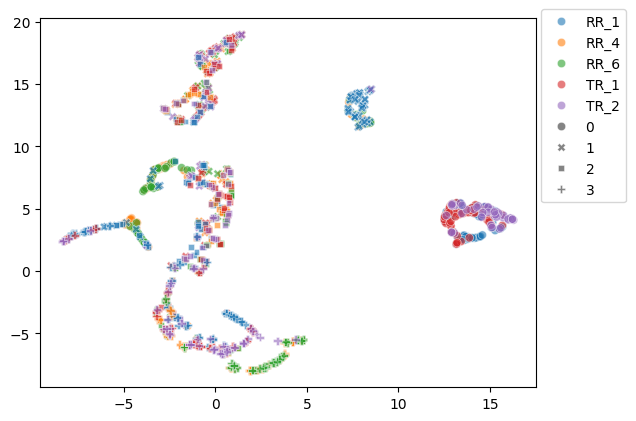

In [29]:
ax = sns.scatterplot(x=umap[:,0],y=umap[:,1],hue=plate_labels*4,alpha=0.6,style=time_labels)
sns.move_legend(ax,(1.01,0.5))

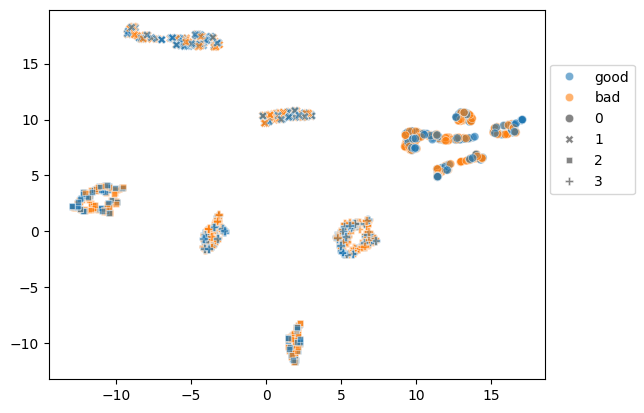

In [30]:
ax =sns.scatterplot(x=umap_context[:,0],y=umap_context[:,1],hue=labels*4,alpha=0.6,style=time_labels)
sns.move_legend(ax,(1.01,0.5))

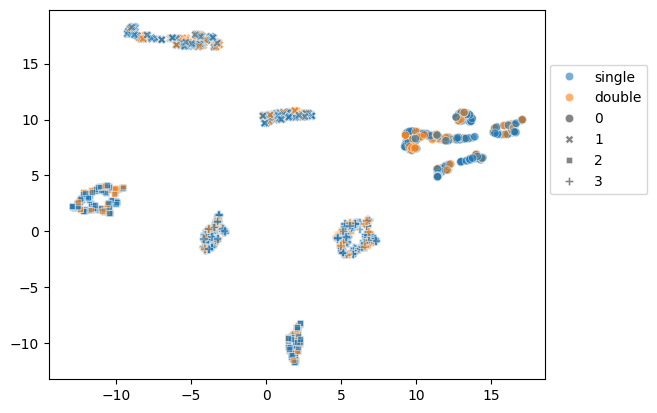

In [31]:
ax = sns.scatterplot(x=umap_context[:,0],y=umap_context[:,1],hue=axis_labels*4,alpha=0.6,style=time_labels)
sns.move_legend(ax,(1.01,0.5))

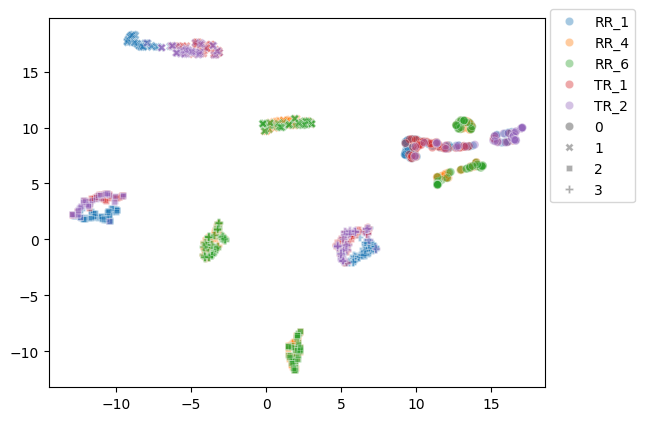

In [32]:
ax =sns.scatterplot(x=umap_context[:,0],y=umap_context[:,1],hue=plate_labels*4,alpha=0.4,style=time_labels)
sns.move_legend(ax,(1.01,0.5))

In [33]:
time_poitns_sep_lat = [latents[:,:,i] for i in range(n_time)]
umaps_per_t = [
    UMAP(
        n_neighbors=30
    ).fit_transform(
        StandardScaler().fit_transform(tp)
    ) for tp in time_poitns_sep_lat
]

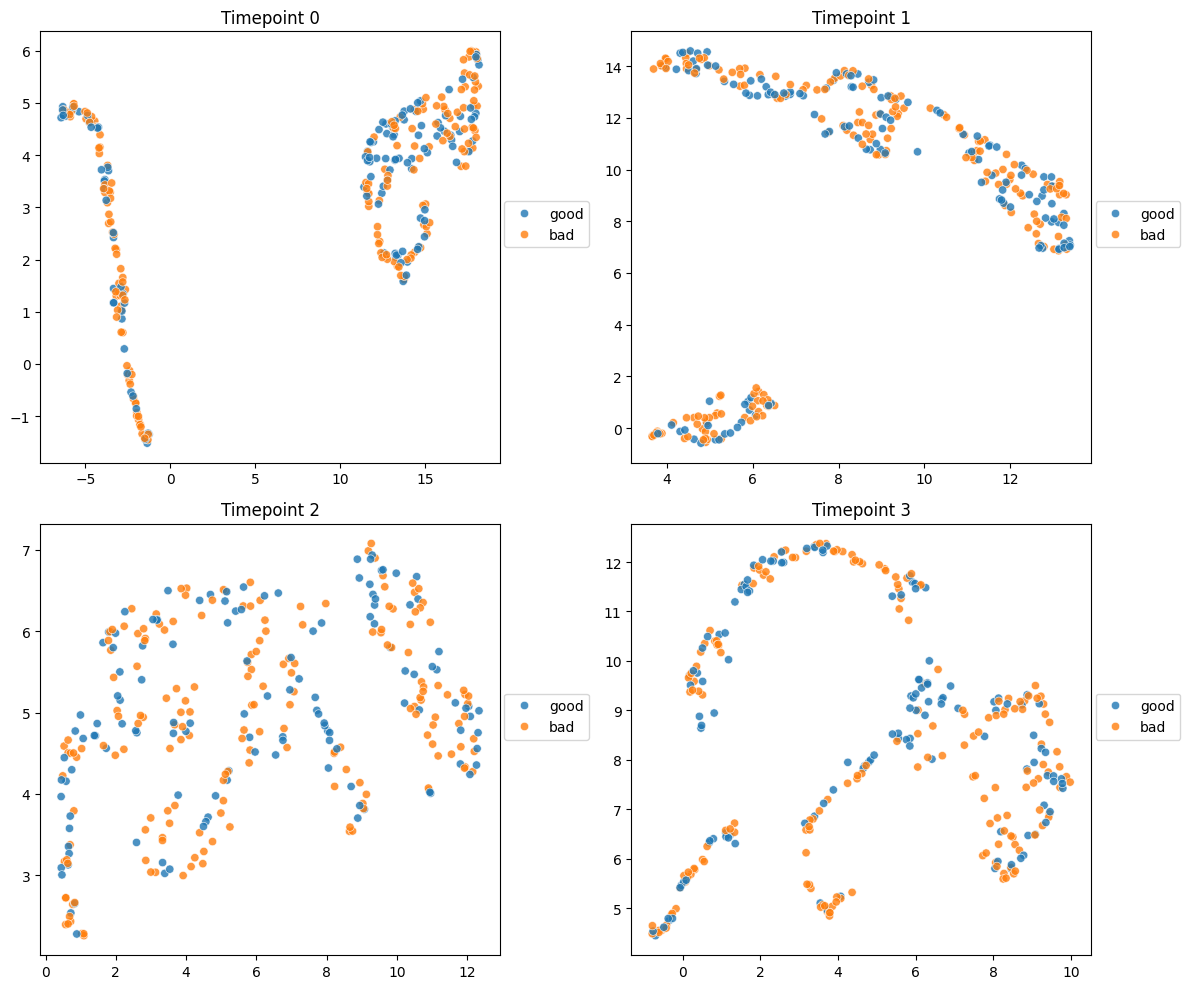

In [34]:
fig, axs = plt.subplots(2,2,figsize=(12,10))

for i, (ump, ax) in enumerate(zip(umaps_per_t,axs.flatten())):
    sns.scatterplot(
        x=ump[:,0],
        y=ump[:,1],
        hue=labels,
        alpha=0.8,
        ax=ax
    )
    ax.set_title(f"Timepoint {i}")
    sns.move_legend(ax,(1.01,0.5))

plt.tight_layout()

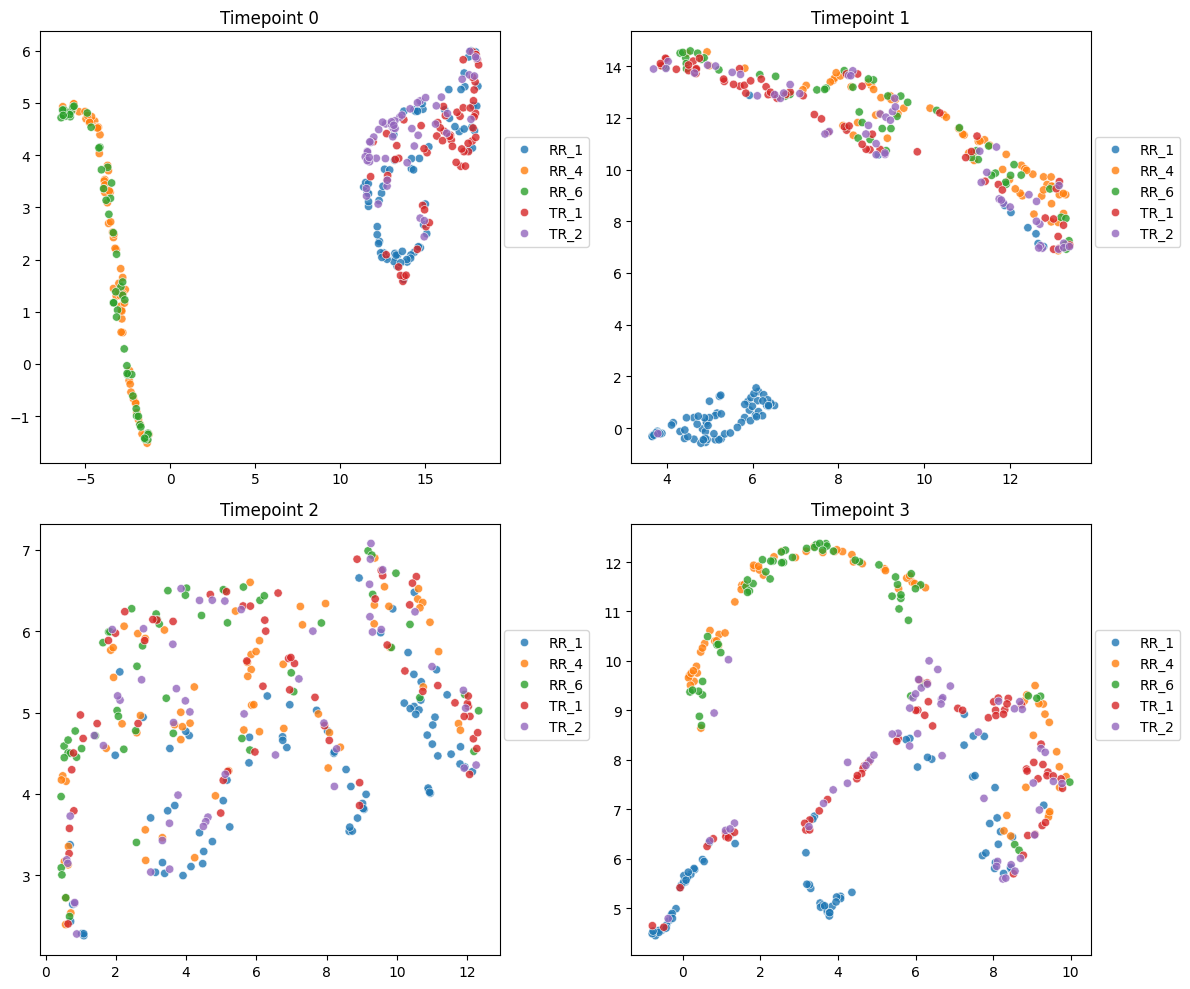

In [35]:
fig, axs = plt.subplots(2,2,figsize=(12,10))

for i, (ump, ax) in enumerate(zip(umaps_per_t,axs.flatten())):
    sns.scatterplot(
        x=ump[:,0],
        y=ump[:,1],
        hue=plate_labels,
        alpha=0.8,
        ax=ax
    )
    ax.set_title(f"Timepoint {i}")
    sns.move_legend(ax,(1.01,0.5))

plt.tight_layout()

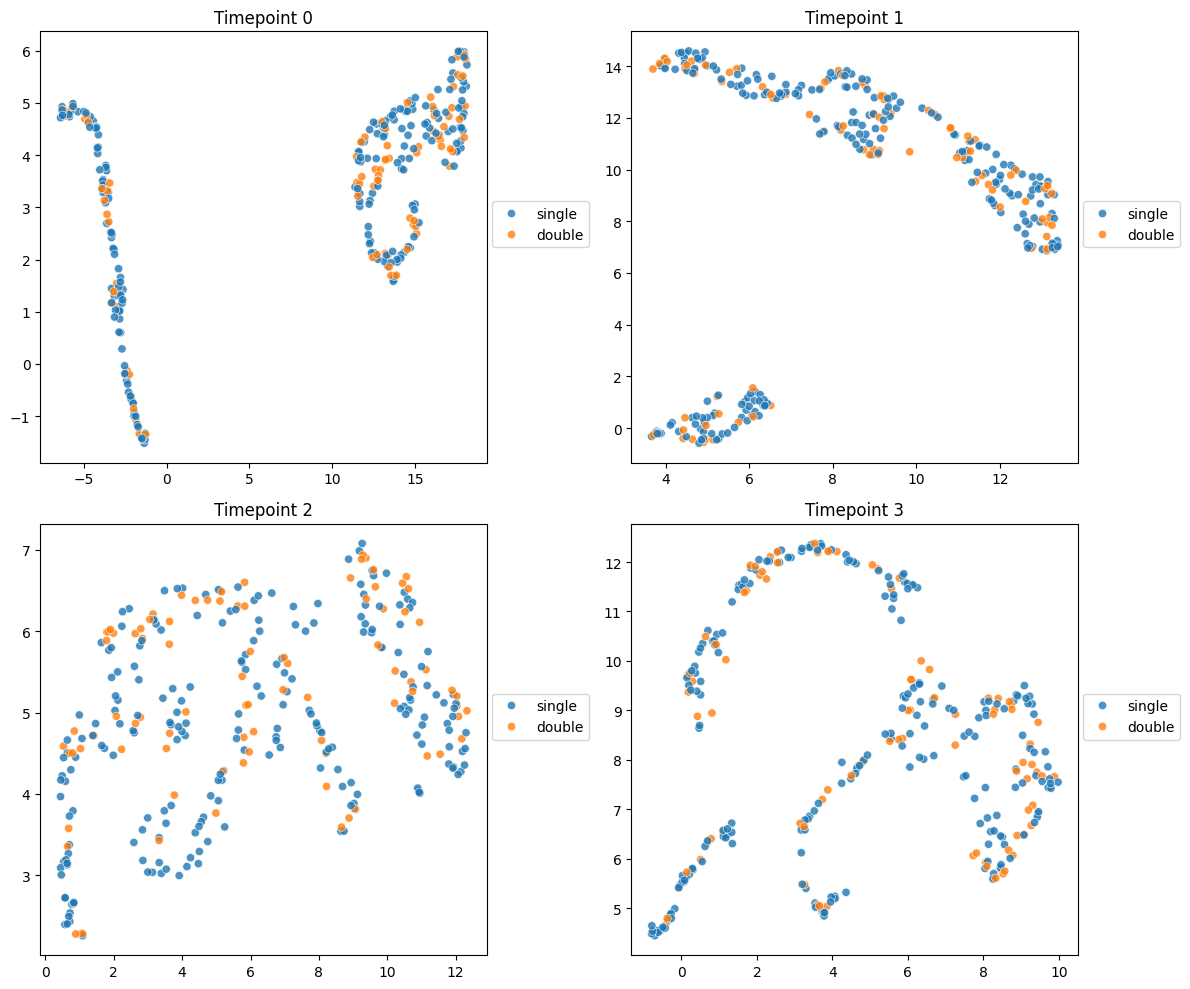

In [37]:
fig, axs = plt.subplots(2,2,figsize=(12,10))

for i, (ump, ax) in enumerate(zip(umaps_per_t,axs.flatten())):
    sns.scatterplot(
        x=ump[:,0],
        y=ump[:,1],
        hue=axis_labels,
        alpha=0.8,
        ax=ax
    )
    ax.set_title(f"Timepoint {i}")
    sns.move_legend(ax,(1.01,0.5))

plt.tight_layout()